In [1]:
import numpy as np
from scipy import signal
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax


In [2]:
# Blind source separation problem (BSS)
np.random.seed(0)
ns = np.linspace(0, 100, 100)
# Sources
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))])
# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])
# Mixed signals
X = A @ S
n_sources, n_samples = S.shape
n_signals = X.shape[0]

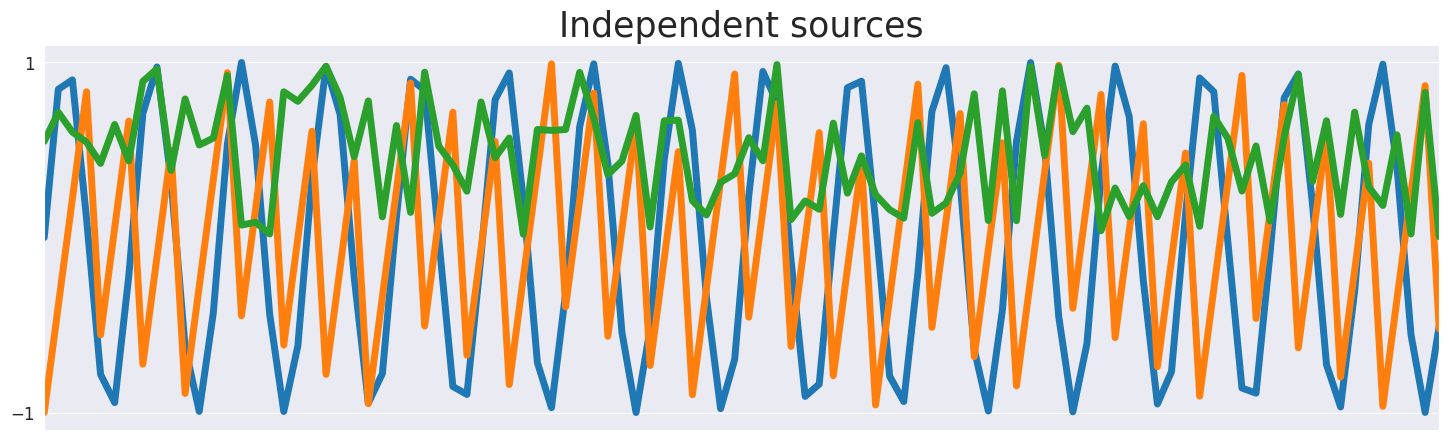

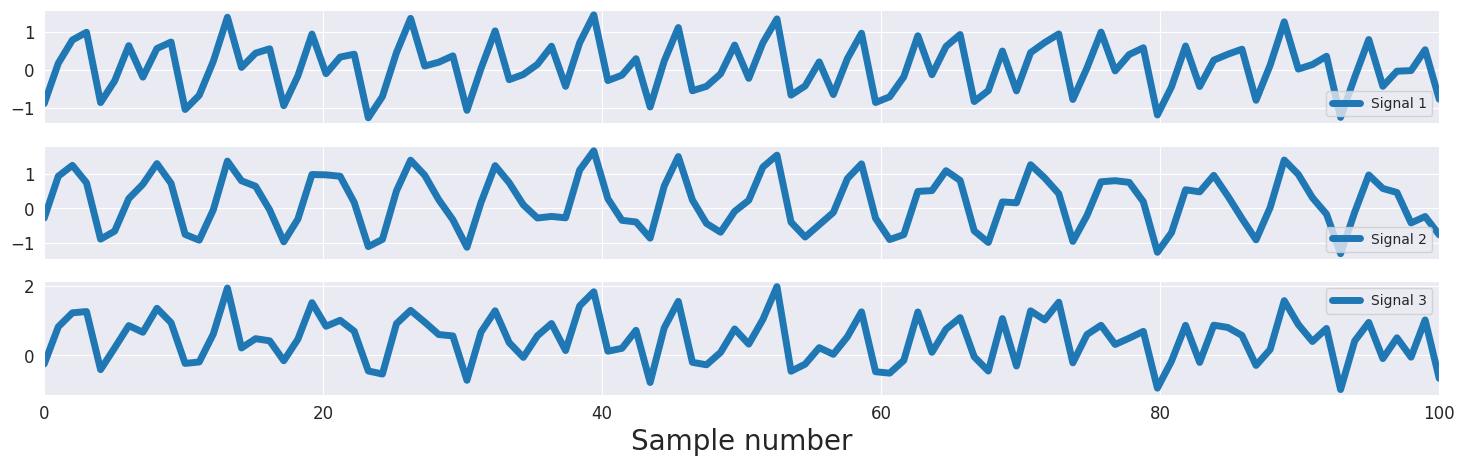

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S.T, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[-1])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 5], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(ns, X[signal_number], lw=5, label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params(labelsize=12)
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number', fontsize=20)
ax[-1].set_xlim(ns[0], ns[-1])
plt.show()

In [4]:
# Define two uniform components
s = np.random.rand(2, 1000)

# Define two gaussian components
sn = np.random.normal(size=(2, 1000))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28], [0.28, 0.96]))

# Mix signals
mixedSignals = A @ s
mixedSignalsN = A @ sn

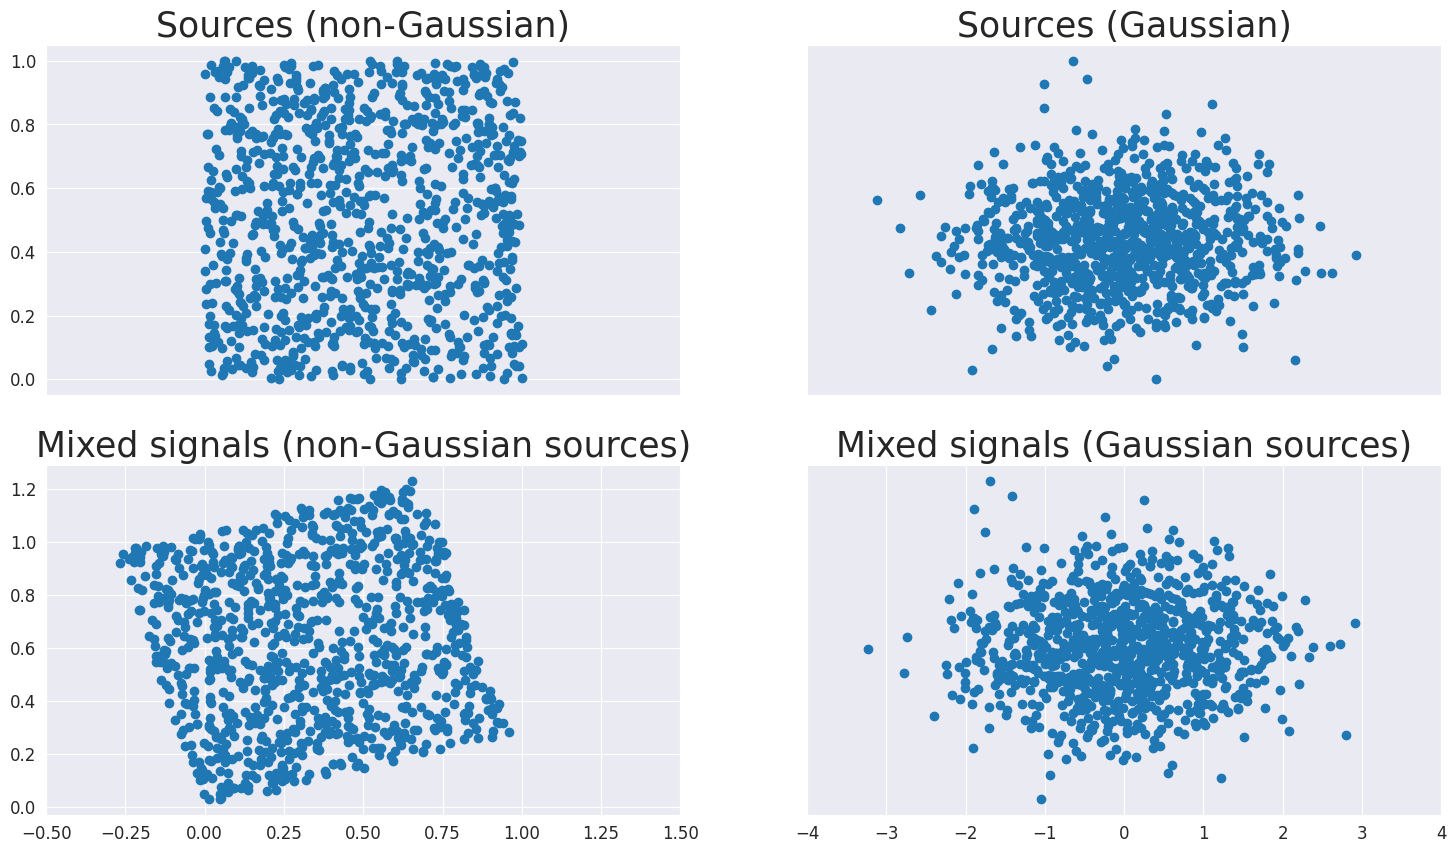

In [5]:
# Plot samples
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.5, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals[0], mixedSignals[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.5, 1.5])

ax[1][1].scatter(mixedSignalsN[0], mixedSignalsN[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

### Visualize properties of toy signals

To check if the properties discussed above also apply for our toy signals we will plot them accordingly.
As expected the source signals are distributed on a square for non-Gaussian random variables. Likewise the mixed signals form a parallelogram in the right plot of Figure 3 which shows that the mixed signals are not independent anymore.

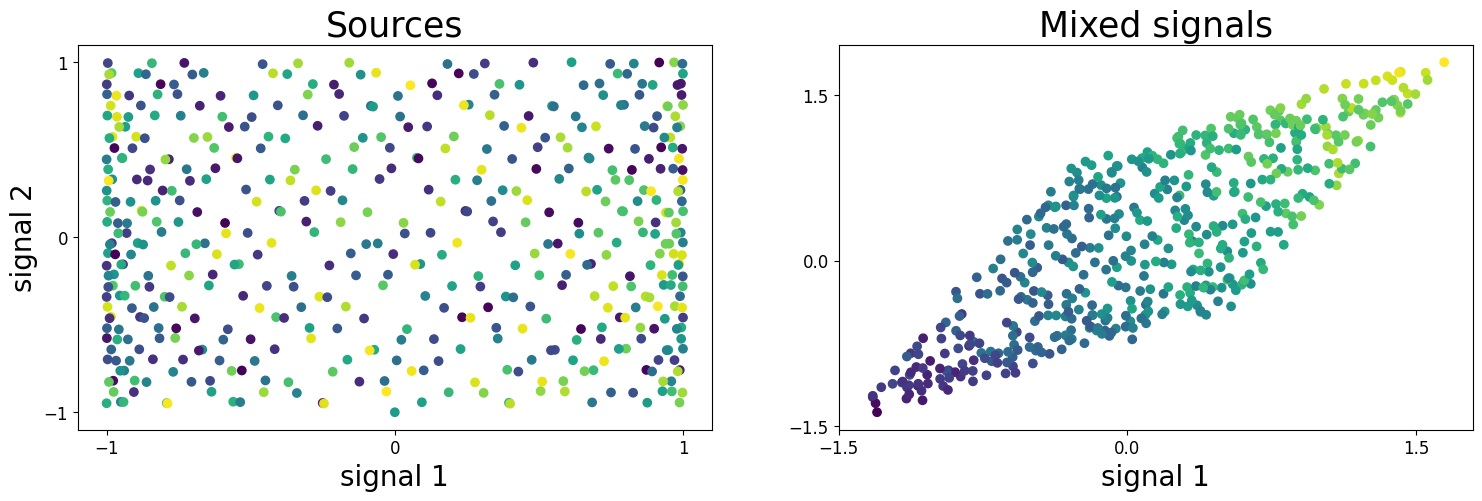

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S[0], S[1], c=S[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

## Importing needed functions.


In [24]:
from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica import fast_ica as fastica
from mva_independent_component_analysis.fast_ica.discriminating_fastica import fast_ica as discriminating_fastica
from mva_independent_component_analysis.mle_ica.gradient import gradient_ica

## 1. Fast ICA algorithm as an approx negentropy maximisation problem

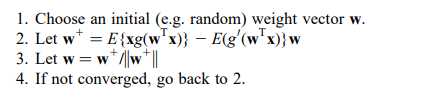


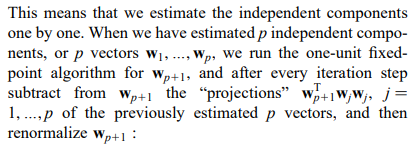

In [25]:
#Nour's implementation of FastICA.
def fastIcaNour(signals, alpha=1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
        w = W[c, :].copy().reshape(m, 1)
        w = w / np.sqrt((w ** 2).sum())

        i = 0
        while (i < iterations):

            # Dot product of weight and signal
            wTx = np.dot(w.T, signals)

            # Pass w*s into contrast function g
            gwTx = np.tanh(wTx * alpha).T

            # Pass w*s into g prime
            g_wTx = (1 - np.square(np.tanh(wTx))) * alpha

            # Update weights
            w_ = (signals * gwTx.T).mean(axis=1) - g_wTx.mean() * w.squeeze()

            # Decorrelate weights
            w_ = w_ - np.dot(np.dot(w_, W[:c].T), W[:c])

            # Normalize
            w_ = w_ / np.sqrt((w_ ** 2).sum())

            # Calculate limit condition
            w_ /= np.linalg.norm(w_)

            if np.abs(np.abs((w_ * w).sum()) - 1) < thresh:
                break

            # Update weights
            w = w_

            # Update counter
            i += 1

        W[c, :] = w.T
    return W

### Pre-processing

So... before we run the ICA we need to do the pre-processing.

In [26]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(X)

### Running the ICA

In [27]:
JAX_KEY = jax.random.PRNGKey(1337)

W_fastIcaNour = fastIcaNour(X, 1, 1e-8, 5000).T  #Nour's method.
W_fastIca = fastica(JAX_KEY, X, X.shape[0], 1e-8, jnp.tanh, 5000)  #Yvann's method
W_fastIcaDiscriminating = discriminating_fastica(JAX_KEY, X, X.shape[0], 1e-8,
                                                 5000)  #Fast ICA discriminating between sub and super gaussian sources
W_gradientdescent = gradient_ica(JAX_KEY, X, X.shape[0], 1e-8, 500000, g=None)  #Gradient descent with kurtosis rule
#Un-mix signals using
unMixed = W_fastIcaNour @ X

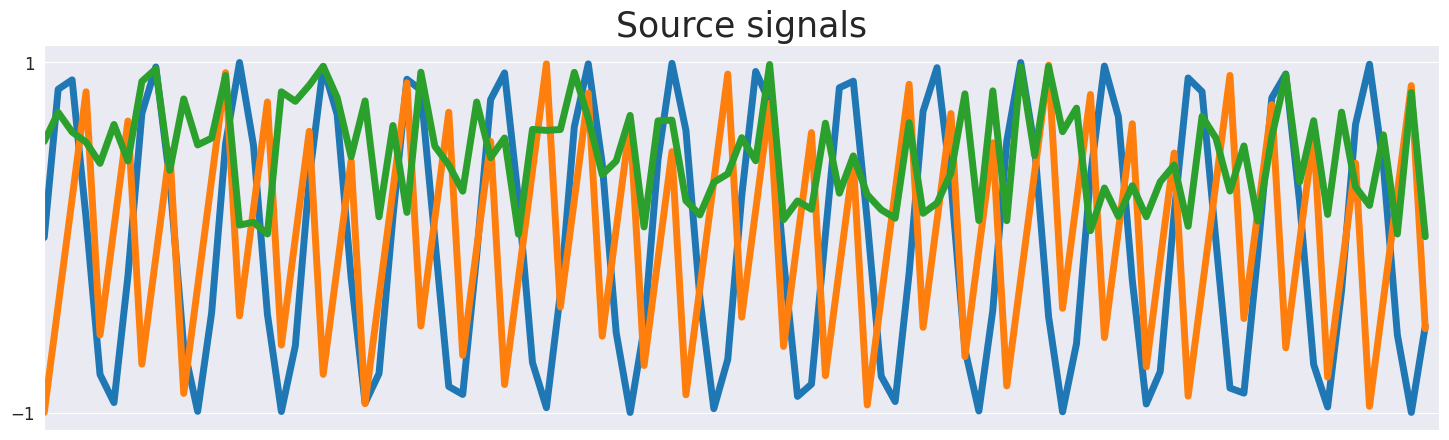

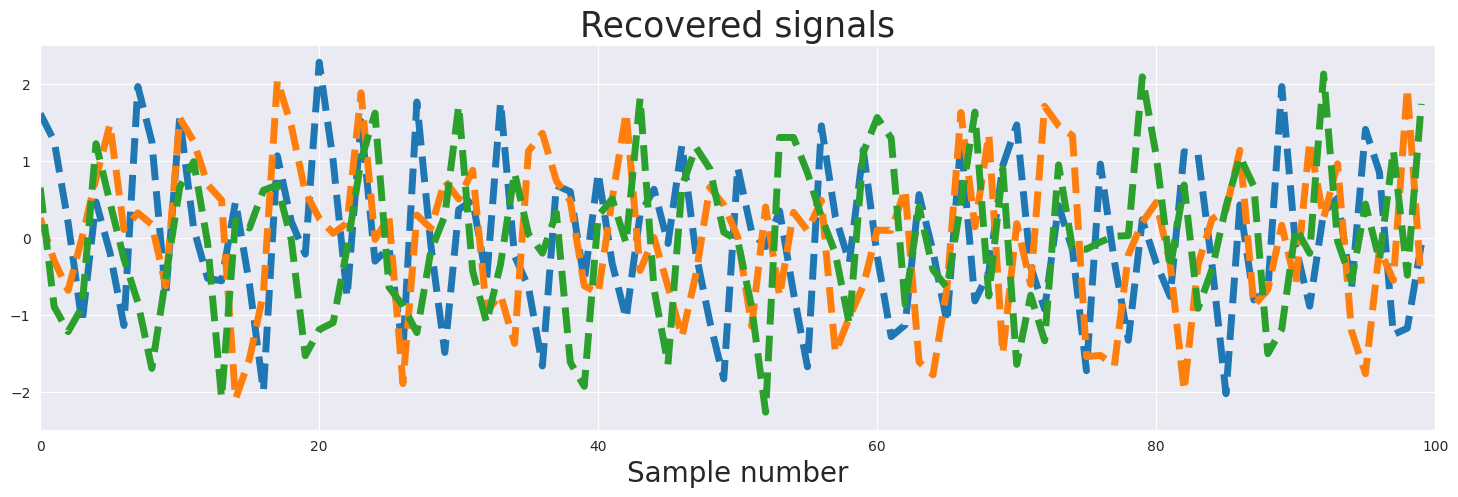

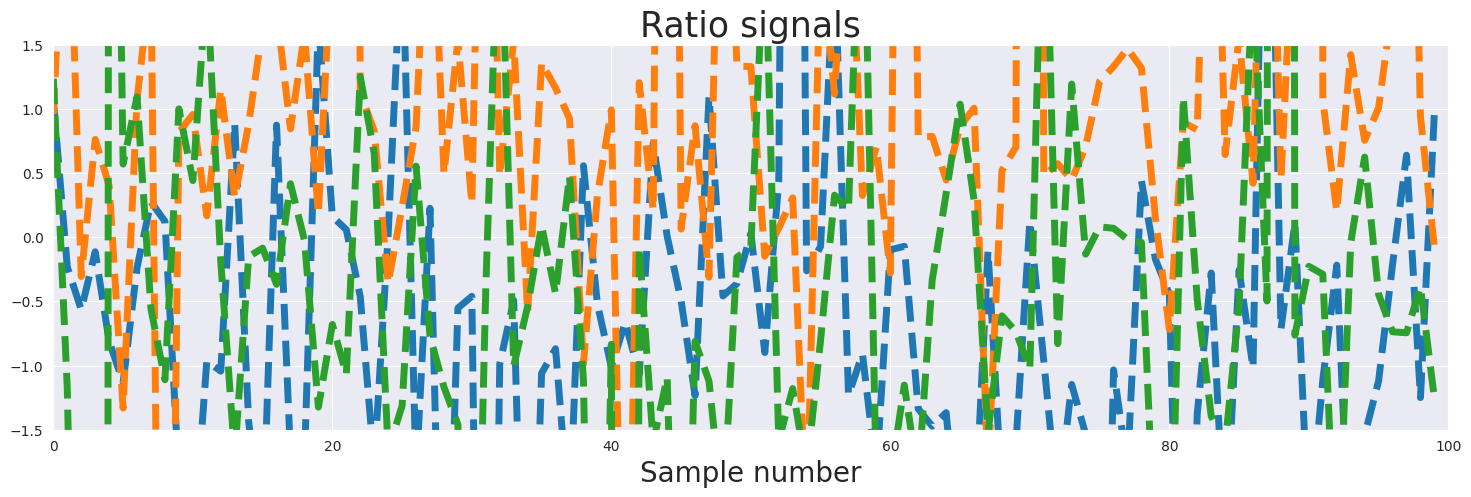

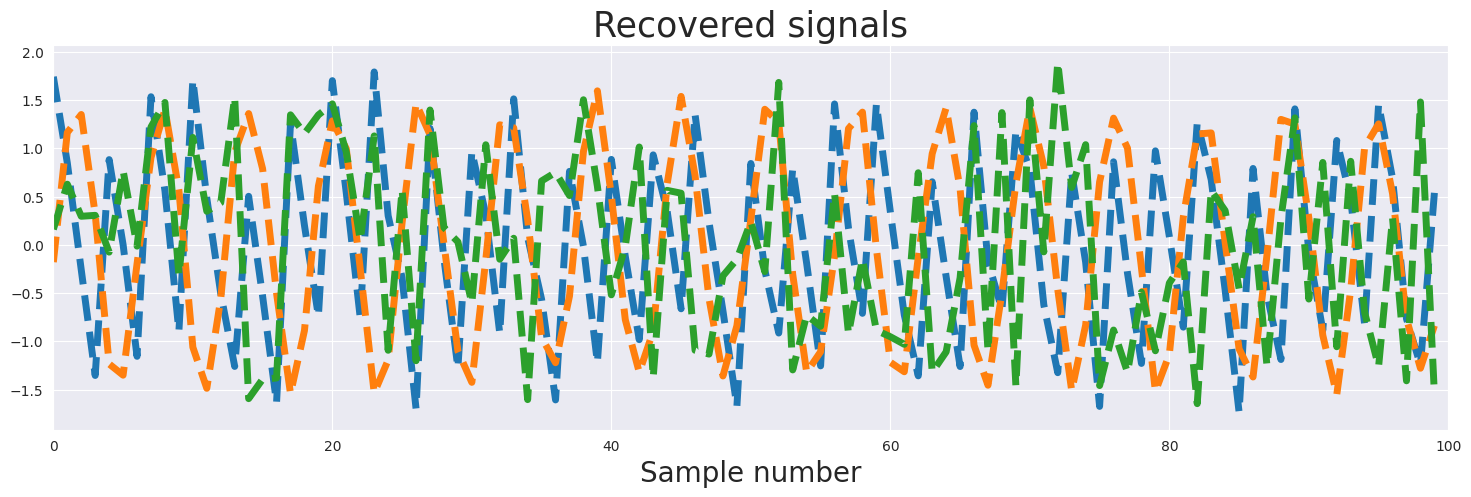

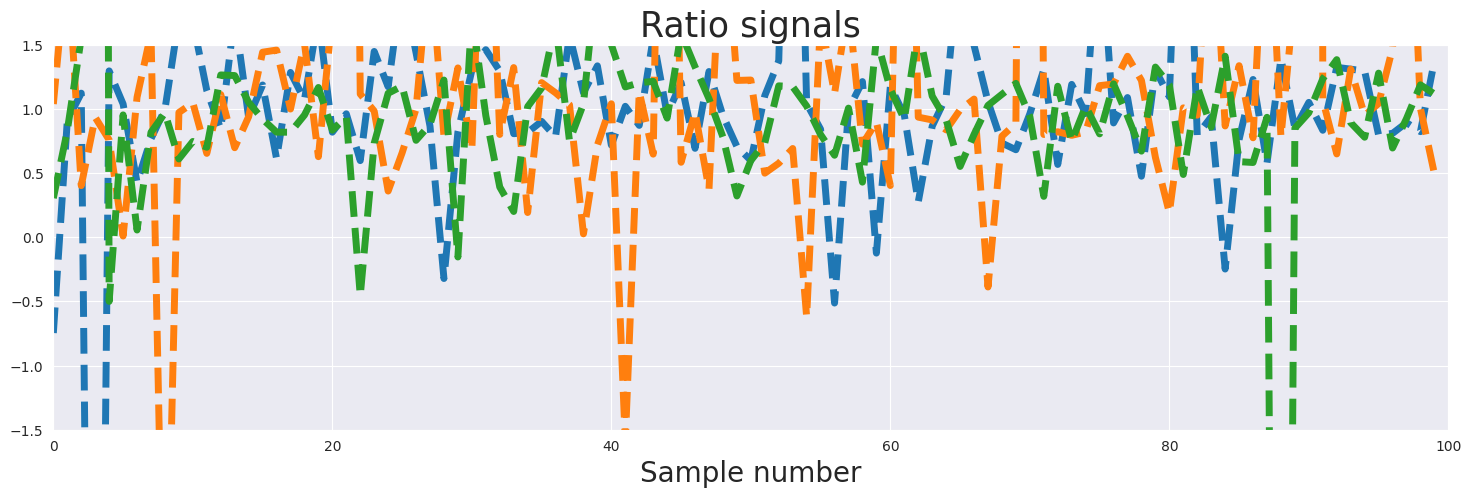

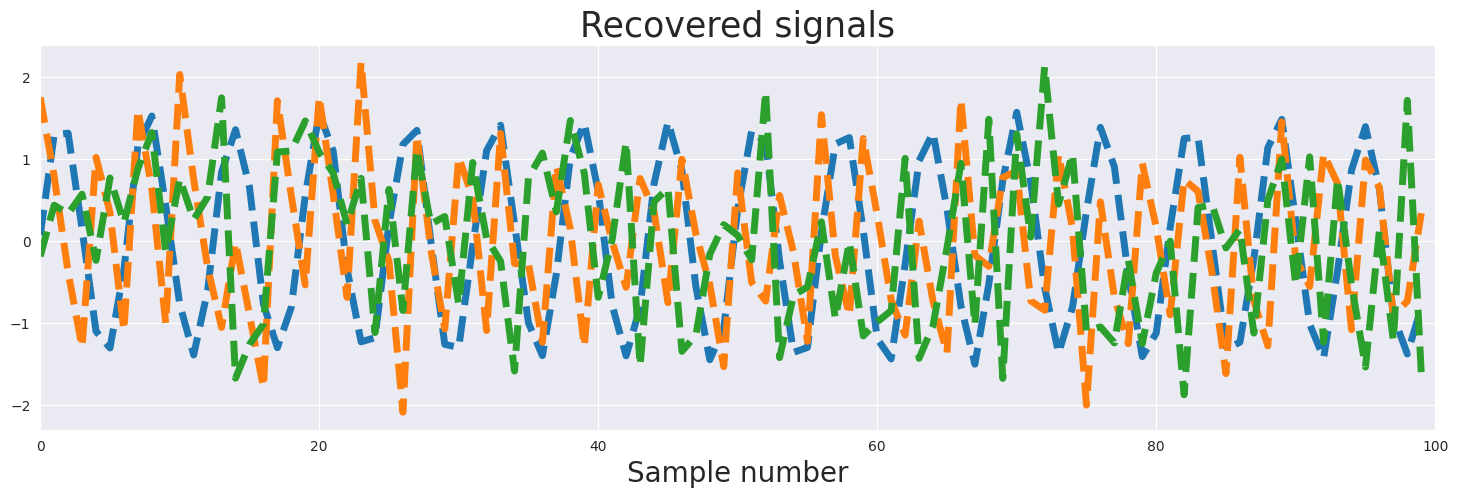

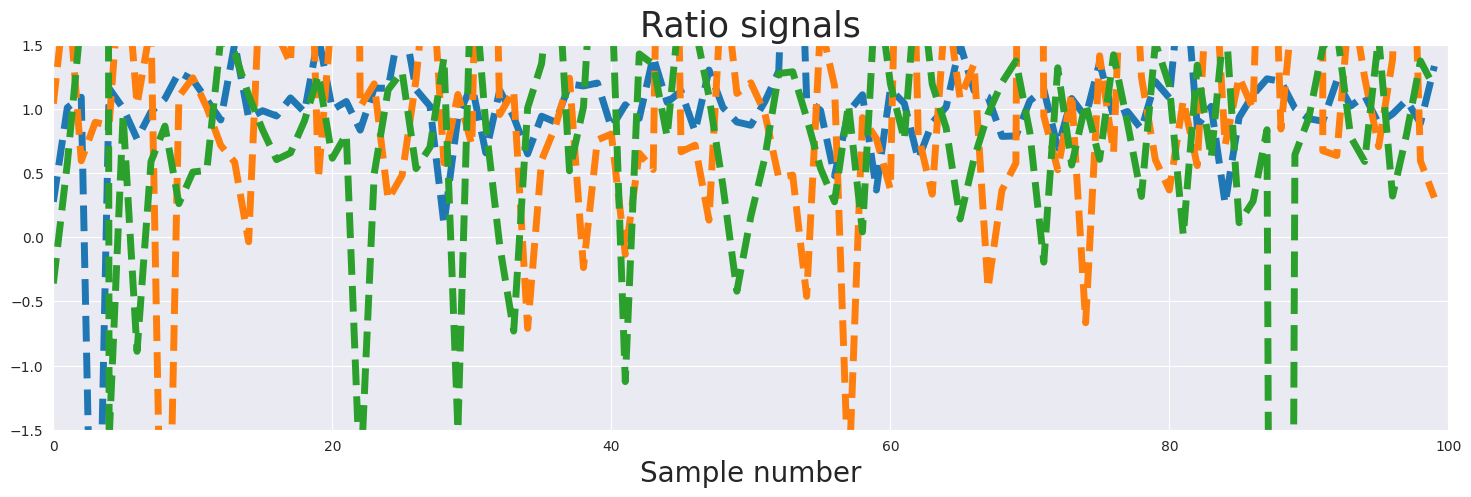

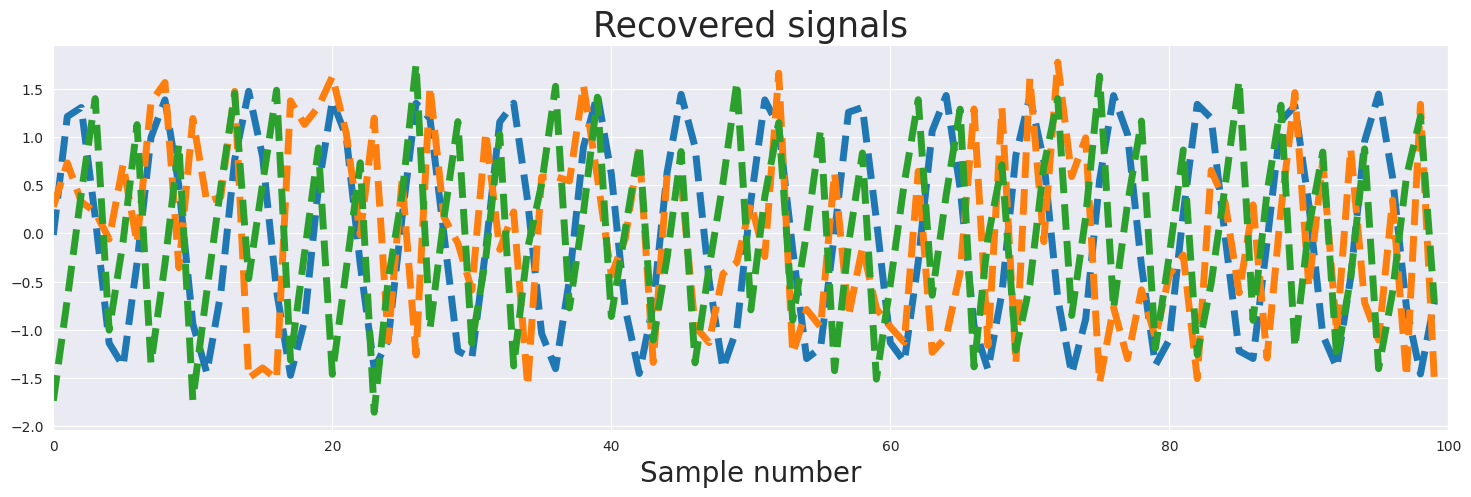

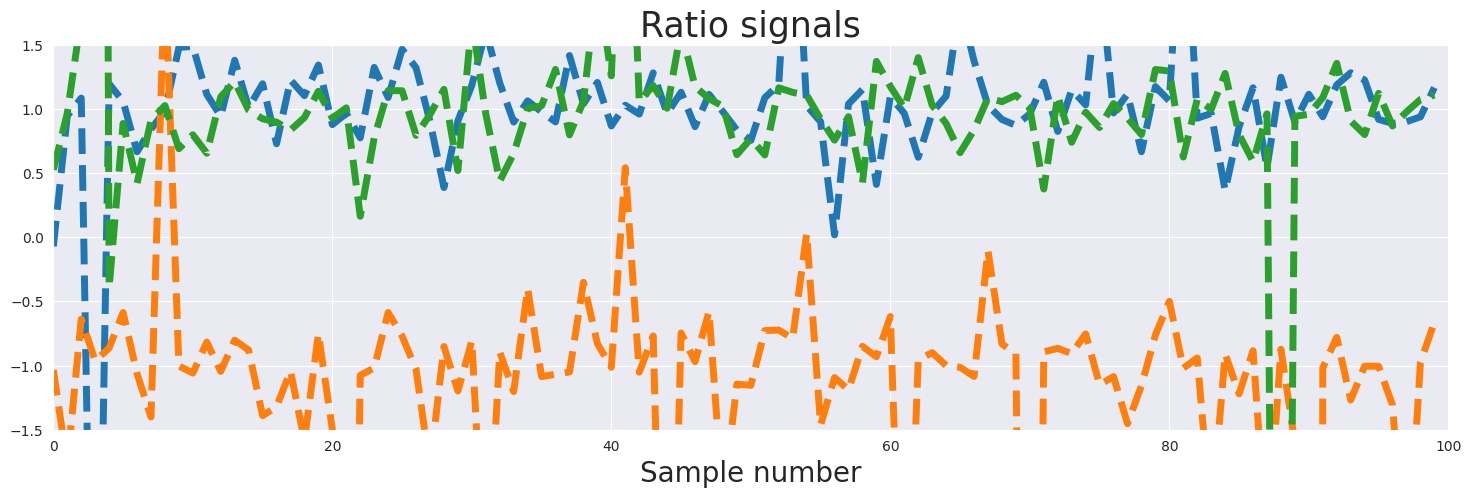

In [29]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S.T, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, S.shape[1])  #ns[-1] depends


def plot_recovered_signals(unMixed):
    fig, ax = plt.subplots(1, 1, figsize=[18, 5])
    ax.plot(unMixed.T, '--', label='Recovered signals', lw=5)
    ax.set_xlabel('Sample number', fontsize=20)
    ax.set_title('Recovered signals', fontsize=25)
    ax.set_xlim(0, S.shape[1])

    Sw, _, _ = centering_and_whitening(S)
    perm = jnp.argmax(jnp.abs(unMixed @ S.T),
                      axis=0)

    fig, ax = plt.subplots(1, 1, figsize=[18, 5])
    for i in range(n_sources):
        ax.plot(unMixed[perm[i]] / Sw[i], '--', label='Recovered signals', lw=5)
    ax.set_xlabel('Sample number', fontsize=20)
    ax.set_title('Ratio signals', fontsize=25)
    ax.set_xlim(0, S.shape[1])
    ax.set_ylim(-1.5, 1.5)
    plt.show()

plot_recovered_signals(W_fastIcaNour@X)
plot_recovered_signals(W_fastIca@X)
plot_recovered_signals(W_fastIcaDiscriminating@X)
plot_recovered_signals(W_gradientdescent@X)

The result of the ICA are plotted above, and the result looks very good. We got all three sources back!

## Kurtosis

So finally lets check one last thing: The kurtosis of the signals.

NameError: name 'unMixed' is not defined

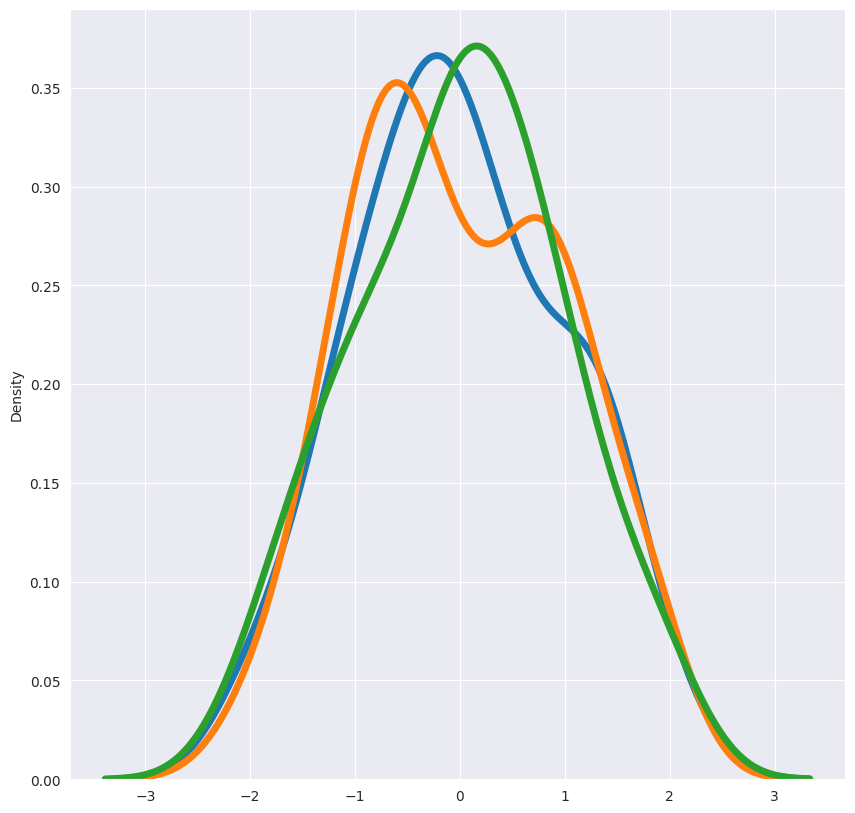

In [8]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(X.shape[0]):
    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurtosis(X[i, :]), decimals=1)))

for i in range(X.shape[0]):
    sns.kdeplot(unMixed[i, :], lw=5, ls='--',
                label='unMixed (source) Kurtosis={}'.format(np.around(kurtosis(unMixed[i, :]), decimals=1)))

ax.tick_params(labelsize=12)
ax.legend()

ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()

# 2. Fast ICA as a MLE problem


Hyvarinen, A. (1999b). The fixed-point algorithm and maximum likelihood
estimation for independent component analysis. Neural Processing
Letters, 10 (1), 1–5.

In [47]:
def fastICA_MLE(X, beta, max_iter=1000, tol=1e-5):
    n_features = X.shape[1]
    V = np.eye(n_features)  # Initialize V as the identity matrix

    for i in range(max_iter):
        V_old = V.copy()
        y = V @ X.T  # y = Vx
        g_y = np.tanh(y)  # Apply the function g to y
        D = np.diag(1.0 / (beta + np.mean(g_y * y, axis=1)))  # D is the inverse of diag(beta_i + E{g'(y_i)})

        # Update rule for V
        V += D @ (np.diag(-beta) + np.mean(g_y[None, :] * y[:, None, :], axis=2)) @ V

        # Check for convergence
        if np.linalg.norm(V - V_old) < tol:
            break

    return V


### Running the ICA

In [46]:
# Center & whiten signals
Xc, meanX = demeaning(X)
Xw, whiteM = whitening(Xc)

In [50]:
beta = np.random.rand(3)
W = fastICA_MLE(Xw, beta).T

#Un-mix signals using
unMixed = W.T @ Xw

# Subtract mean
unMixed = unMixed - meanX

ValueError: ignored

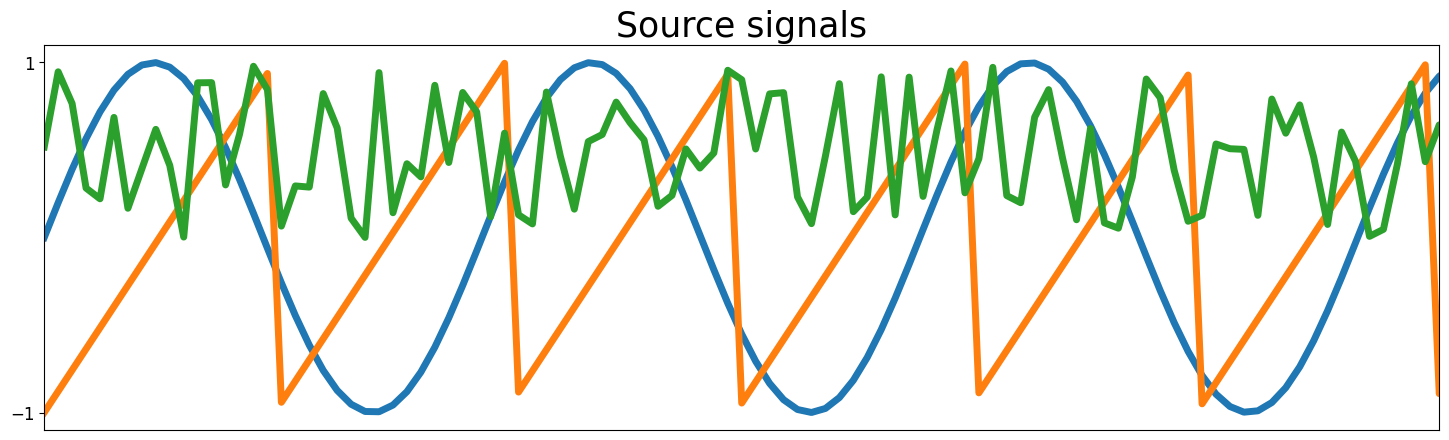

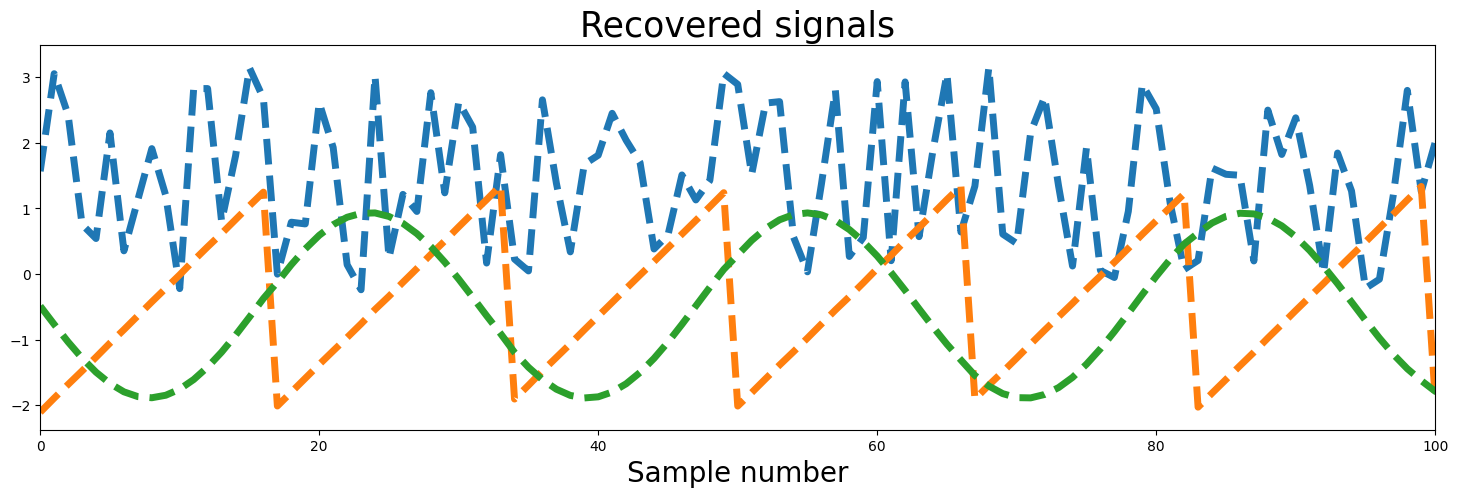

In [ ]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S.T, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed.T, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

The result of the ICA are plotted above, and the result looks very good. We got all three sources back!